<a href="https://colab.research.google.com/github/alexanderkeijser73/music_metriclearning/blob/master/colab_tricks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Colab & TensorFlow
## A Kick Snare Classifier

This notebook introduces basic things you need to know when using Colab for training neural networks.

You will learn how to 
1.   Make sure you have a GPU
2.   Interact with Google Drive
3.   Pre-process audio files
4.   Use TensorFlow & Keras to build a simple classifier
5.   Trick to avoid Colab disconnections

---

# 1. Make sure you have a GPU and that it is not used
You will need to select GPU in this menu:

`Runtime > change runtime type > Hardware accelerator > GPU`


Then we check that we have been assigned a GPU, and that no one else is using it. You should see something like: 

```
Gen RAM Free: 12.7 GB  | Proc size: 156.8 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB
```

If you see that Util is more than 0%, it means you are sharing the GPU with another user. Restart your runtime...



In [0]:
# we use %%capture for supressing the output of this cell
%%capture

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [0]:
import psutil
import humanize
import os
import GPUtil as GPU


def printm():
    GPUs = GPU.getGPUs()
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[0]
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.8 GB  | Proc size: 156.8 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


# 2. Interact with Google Drive 
## Mount Google Drive folder
Now we are going to mount our Google Drive folder.
Run the next cell and follow the procedure.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Notice we use `%cd` instead of `!cd`. Read more about it [here](https://stackoverflow.com/questions/36512527/cd-vs-cd-vs-cd-in-ipython).

In [0]:
%cd '/content/gdrive/My Drive/SMC_Colab_Intro/'
!ls 

/content/gdrive/My Drive/SMC_Colab_Intro
 checkpoints			    kick_snare_dataset.json   sounds
 deep_kick_snare_classifier.ipynb   labels.npy		      specs.npy
'HPC ressources slides.gslides'     SMC_Colab_Intro.zip


# 3. Pre-process audio files
For this session, we created a small dataset of 2500 snare and kick samples from Freesound.
In the following, we define some utilitary functions, and will start pre-processing the audio files.

In [0]:
%%capture
!pip install essentia

In [0]:
import os
sound_files = os.listdir('./sounds/')

In [0]:
import sys
import numpy as np
import essentia.standard as es
from essentia import Pool
import matplotlib.pyplot as plt


def pad(l, sr):
    # 0-Pad 1 sec at fs hz and add little noise
    z = np.zeros(sr, dtype='float32')
    z[:l.size] = l
    z = z + 5*1e-4*np.random.rand(z.size).astype('float32')
    return z


def compute_spectrogram(filename, sr=16000, n_mels=32):
    # compute log mel magnitude spectrogram 
    audio = es.MonoLoader(filename=filename,sampleRate=sr)()
    audio = pad(audio, sr)

    # old code using librosa
    # audio_rep = librosa.feature.melspectrogram(y=x, sr=sr, hop_length=512, n_fft=1024, n_mels=n_mels, power=1.)
    # audio_rep = np.log(audio_rep + np.finfo(np.float32).eps)
    
    # essentia extractor
    windowing = es.Windowing(type='hann', normalized=False, zeroPadding=0)
    spectrum = es.Spectrum()
    melbands = es.MelBands(numberBands=n_mels, 
                           sampleRate=sr, 
                           lowFrequencyBound=0, 
                           highFrequencyBound=8000, 
                           inputSize=(2048)//2+1, 
                           weighting='linear', 
                           normalize='unit_tri', 
                           warpingFormula='slaneyMel', 
                           type='power')
    
    norm10k = es.UnaryOperator(type='identity', shift=0, scale=1)
    log10 = es.UnaryOperator(type='log10')
    results = Pool()

    for frame in es.FrameGenerator(audio, frameSize=1024, hopSize=512, startFromZero=False):
        spectrumFrame = spectrum(windowing(frame))     
        results.add('melbands', log10(norm10k(melbands(spectrumFrame))))
    
    mel_log_spectrum = results['melbands']
    return mel_log_spectrum[:32].T


class ProgressBar:
    """Progress bar
    
    """
    def __init__ (self, valmax, maxbar, title):
        if valmax == 0:  valmax = 1
        if maxbar > 200: maxbar = 200
        self.valmax = valmax
        self.maxbar = maxbar
        self.title  = title
        print ('')

    def update(self, val, avg_loss=0):
        # format
        if val > self.valmax: val = self.valmax

        # process
        perc  = round((float(val) / float(self.valmax)) * 100)
        scale = 100.0 / float(self.maxbar)
        bar   = int(perc / scale)

        # render
        if avg_loss:
            out = '\r %20s [%s%s] %3d / %3d  loss: %.5f' % (
                self.title, 
                '=' * bar, ' ' * (self.maxbar - bar), 
                val, 
                self.valmax, 
                avg_loss, 
                )
        else:
            out = '\r %20s [%s%s] %3d / %3d ' % (self.title, '=' * bar, ' ' * (self.maxbar - bar), val, self.valmax)

        sys.stdout.write(out)
        sys.stdout.flush()

(32, 32)
142506.wav


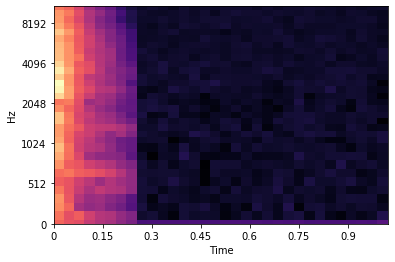

In [0]:
import librosa.display
from IPython.display import Audio


sound = sound_files[100]

x = compute_spectrogram('./sounds/{}'.format(sound))
print(x.shape)
librosa.display.specshow(x, sr=16000, x_axis='time', y_axis='mel')

print(sound)
Audio('./sounds/{}'.format(sound))

We already computed the spectrograms and stored them in a Google drive folder.
This process can take time in Colab, because of slow CPU and slow data loading from the drive. You could also compute these spectrograms localy on your computer and then upload a file to Google Drive.

In [0]:
import json


if False:
    dataset = json.load(open('./kick_snare_dataset.json', 'rb'))
    specs = np.zeros((2500, 32, 32))
    labels = np.zeros((2500, 2))

    progress_bar = ProgressBar(len(sound_files), 20, 'Computing spec...')
    progress_bar.update(0)

    for idx, file in enumerate(sound_files):
        progress_bar.update(idx+1)

        specs[idx] = compute_spectrogram('./sounds/{}'.format(file))
        labels[idx] = [1,0] if dataset[file.split('.')[0]] == 'kick' else [0,1]

    np.save('./specs.npy', specs)
    np.save('./labels.npy', labels)

# 4. Use TensorFlow & Keras to build a simple classifier

Here we will use tensorflow to train neural networks to classify audio samples.

We first make sure that our GPU calculates faster than the CPU...

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

TensorFlow 2.x selected.
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.3239870499999142
GPU (s):
0.05171182799995222
GPU speedup over CPU: 64x


### Class and function for plots

In [0]:
%matplotlib inline
from IPython.display import clear_output


class TrainingPlot(tf.keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        #self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        #self.val_acc.append(logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            #plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            #plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

## Define and train model

Note that in this notebook when we compute the spectrograms and train our models, we keep all the data in memory. This approach will not work with large dataset that cannot fit into memory. You will have to implement a different logic for loading the data. With Keras you can have a look at some examples that use the `fit_generator()` method for training the model (e.g. [here](https://mc.ai/train-keras-model-with-large-dataset-batch-training/)).

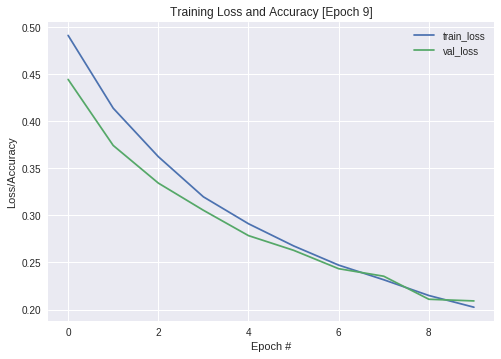

2000/2000 [==============================] - 0s 215us/sample - loss: 0.2024 - accuracy: 0.9730 - val_loss: 0.2091 - val_accuracy: 0.9580


In [0]:
!mkdir './checkpoints'
import json


specs = np.load('./specs.npy')
labels = np.load('./labels.npy')

specs = specs.reshape(-1, 32, 32, 1)
specs = (specs - np.mean(specs)) / np.std(specs)

train_labels = labels[:2000].reshape(-1, 2)
test_labels = labels[2000:].reshape(-1, 2)

train_specs = specs[:2000]
test_specs = specs[2000:]


def create_vgg_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(32,32,1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


def create_simple_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(2, kernel_size=32, activation='relu', input_shape=(32,32,1), name='conv2D'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model


# Create a basic model instance
#model = create_vgg_model()
model = create_simple_model()

# Display the model's architecture
model.summary()

# Create a callback that saves the model's weights
checkpoint_path = "./checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(train_specs, 
          train_labels,  
          epochs=10,
          validation_data=(test_specs,test_labels),
          callbacks=[plot_losses])  # Pass cp_callback here for saving checkpoints

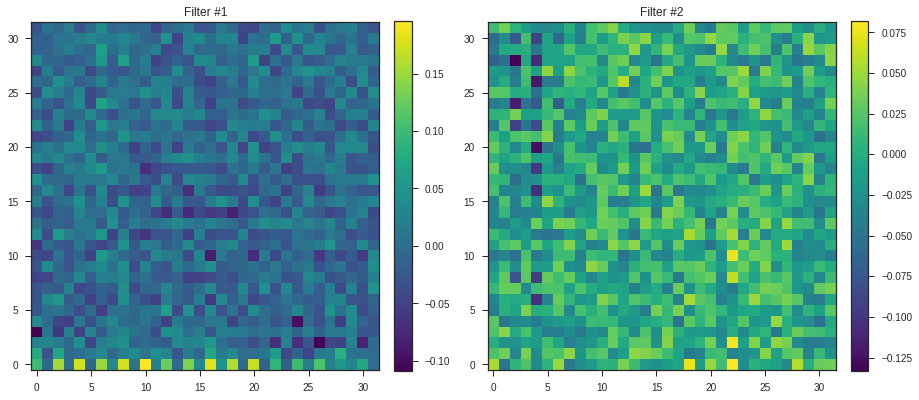

In [0]:
# Visualise the learned filters for the simple model
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')


params = {
    'origin': 'lower',
    'interpolation': 'nearest',
    'cmap': 'viridis',
}

conv_weights = model.get_layer(name='conv2D').get_weights()[0].reshape(2,32,32)
filter1 = conv_weights[0]
filter2 = conv_weights[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

im1 = ax1.imshow(filter1, **params)
ax1.set_title("Filter #1")
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

im2 = ax2.imshow(filter2, **params)
ax2.set_title("Filter #2")
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)



# 5. Preventing disconnections
Colab will disconect automatically if you don't interact with the browser.
One solution to prevent these disconnections is to simulate clicks on the browser.
To do so, open the inspector, go to the console, and type:

```javascript
function ClickConnect(){
  console.log("Working"); 
  document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect, 60000)
```

